# Bank Customer Churn - Deep Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
!pip install opendatasets
import opendatasets as od

#Fetching data from kaggle
dataset_url = 'https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset'

od.download(dataset_url)

Skipping, found downloaded files in "./bank-customer-churn-dataset" (use force=True to force download)


In [3]:
#Load the dataset
data = pd.read_csv('bank-customer-churn-dataset/Bank Customer Churn Prediction.csv')
print(data.shape)

(10000, 12)


In [4]:
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Preprocessing

In [5]:
data.drop(['customer_id'], axis=1, inplace=True)

In [6]:
data = pd.get_dummies(data=data,columns=['country','gender'],drop_first=True)

In [7]:
cols_to_scale = ['credit_score','balance','estimated_salary']

scaler = MinMaxScaler()

data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

In [8]:
data[cols_to_scale] = data[cols_to_scale].round(2)

In [9]:
data.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace infs with NaN
data[cols_to_scale] = data[cols_to_scale].fillna(data[cols_to_scale].mean()) #Fill NaN with mean of column

In [10]:
print(data[['country_Germany', 'country_Spain', 'gender_Male']].head())

   country_Germany  country_Spain  gender_Male
0            False          False        False
1            False           True        False
2            False          False        False
3            False          False        False
4            False           True        False


In [11]:
data[['country_Germany', 'country_Spain', 'gender_Male']] = data[['country_Germany', 'country_Spain', 'gender_Male']].astype(int)

In [12]:
data.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,0.54,42,2,0.00,1,1,1,0.51,1,0,0,0
1,0.52,41,1,0.33,1,0,1,0.56,0,0,1,0
2,0.30,42,8,0.64,3,1,0,0.57,1,0,0,0
3,0.70,39,1,0.00,2,0,0,0.47,0,0,0,0
4,1.00,43,2,0.50,1,1,1,0.40,0,0,1,0


In [13]:
print(data['churn'].value_counts())

churn
0    7963
1    2037
Name: count, dtype: int64


# Splitting data

In [14]:
X = data.drop('churn',axis=1)
y = data['churn']

In [15]:
smote = SMOTE()

X_resample,y_resample = smote.fit_resample(X,y)

In [16]:
y_resample.value_counts()

,count
churn,
1,7963
0,7963


In [17]:
X_train,X_test,y_train,y_test = train_test_split(X_resample,y_resample,test_size=0.2,random_state=1)

In [18]:
print(X_train.shape, y_test.shape)

(12740, 11) (3186,)


In [ ]:
#adasyn = ADASYN(sampling_strategy='minority')
#X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [19]:
# Compute class weights for handling class imbalance
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weight_dict = dict(enumerate(class_weights))

In [20]:
#print("Class Weights: ", class_weight_dict)
#print(X_train.shape)
#print(y_train.shape)

In [21]:
print(X_train.columns)

Index(['credit_score', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'country_Germany',
       'country_Spain', 'gender_Male'],
      dtype='object')


In [22]:
X_train.reset_index(drop=True, inplace=True)
y_train = pd.Series(y_train).reset_index(drop=True)

# Model training


In [23]:
model = Sequential()

model.add(Dense(16,activation='relu',input_dim=X_train.shape[1]))
model.add(Dropout(0.1))

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5292 - loss: 2.2238 - val_accuracy: 0.6786 - val_loss: 0.6253
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6075 - loss: 0.7091 - val_accuracy: 0.7021 - val_loss: 0.5984
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6679 - loss: 0.6315 - val_accuracy: 0.7017 - val_loss: 0.5784
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6918 - loss: 0.5968 - val_accuracy: 0.7159 - val_loss: 0.5598
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7009 - loss: 0.5758 - val_accuracy: 0.7225 - val_loss: 0.5574
Epoch 6/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7086 - loss: 0.5680 - val_accuracy: 0.7221 - val_loss: 0.5604
Epoch 7/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7077 - loss: 0.5630 - val_accuracy: 0.7194 - val_loss: 0.5566
Epoch 8/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7315 - loss: 0.5507 - val_a

# Model Evaluation

In [28]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7869 - loss: 0.4505
Test Accuracy: 0.7884494662284851


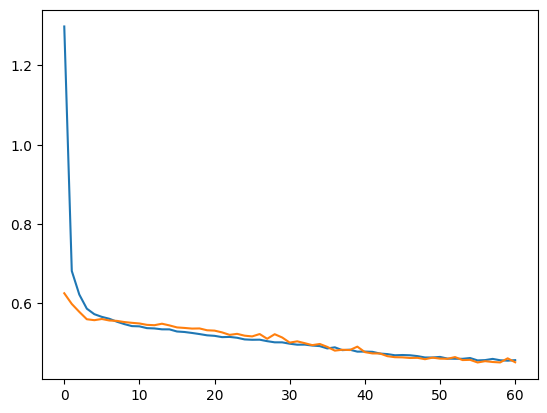

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

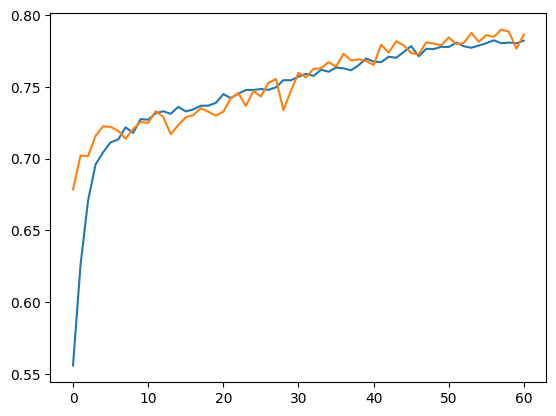

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


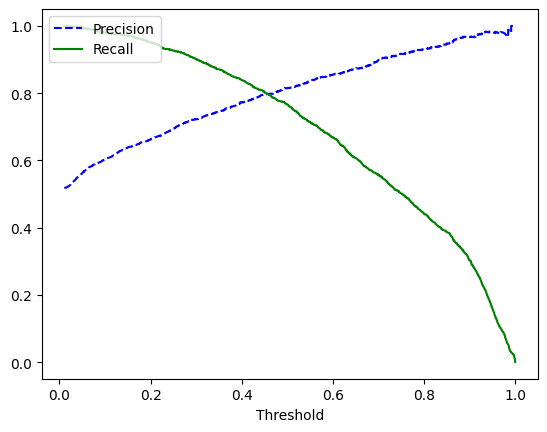

In [31]:
from sklearn.metrics import precision_recall_curve

y_pred_probs = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Plot to find the optimal trade-off
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend(loc="upper left")
plt.xlabel("Threshold")
plt.show()

In [32]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.6).astype(int)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.88      0.79      1534
           1       0.86      0.67      0.75      1652

    accuracy                           0.77      3186
   macro avg       0.78      0.77      0.77      3186
weighted avg       0.79      0.77      0.77      3186



In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
print(f"AUC: {auc_score}")

AUC: 0.772886012292792


In [35]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.ravel()})

mismatches = comparison_df[comparison_df['Actual'] != comparison_df['Predicted']]
print("Mismatched Predictions:")
print(mismatches)

Mismatched Predictions:
       Actual  Predicted
15223       1          0
3964        1          0
8578        0          1
11235       1          0
4429        1          0
...       ...        ...
9126        1          0
13893       1          0
14287       1          0
1454        1          0
13709       1          0

[736 rows x 2 columns]


In [36]:
X_test = pd.DataFrame(X_test, index=y_test.index)

mismatched_data = X_test.loc[mismatches.index]
print(mismatched_data.describe())

       credit_score         age      tenure     balance  products_number  \
count    736.000000  736.000000  736.000000  736.000000       736.000000   
mean       0.596970   39.995924    4.858696    0.375048         1.290761   
std        0.180888    9.930026    2.825854    0.220094         0.486242   
min        0.054811   18.000000    0.000000    0.000000         1.000000   
25%        0.480000   33.000000    3.000000    0.215026         1.000000   
50%        0.600000   39.000000    5.000000    0.430000         1.000000   
75%        0.720000   45.000000    7.000000    0.527623         2.000000   
max        1.000000   83.000000   10.000000    0.890000         3.000000   

       credit_card  active_member  estimated_salary  country_Germany  \
count   736.000000     736.000000        736.000000       736.000000   
mean      0.656250       0.425272          0.483356         0.263587   
std       0.475282       0.494720          0.260676         0.440877   
min       0.000000       0.

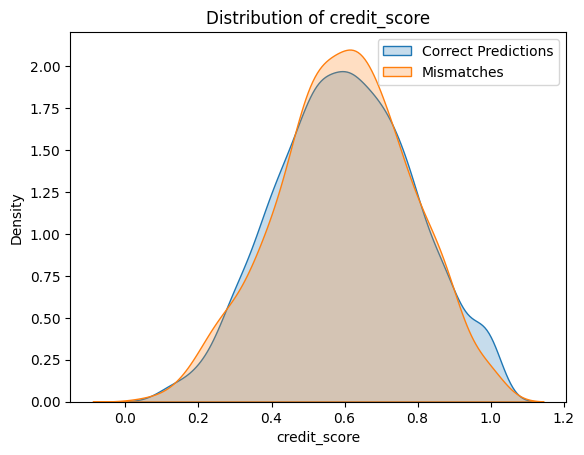

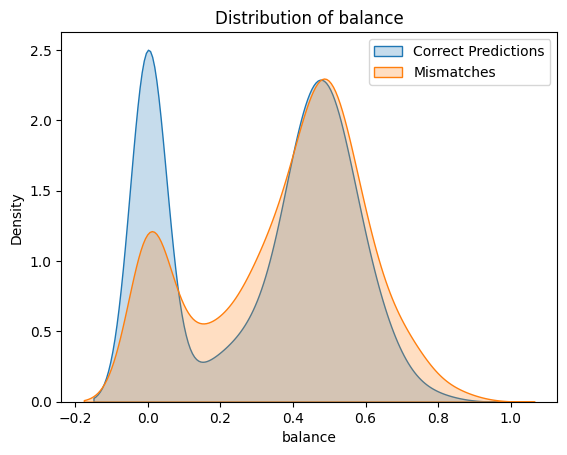

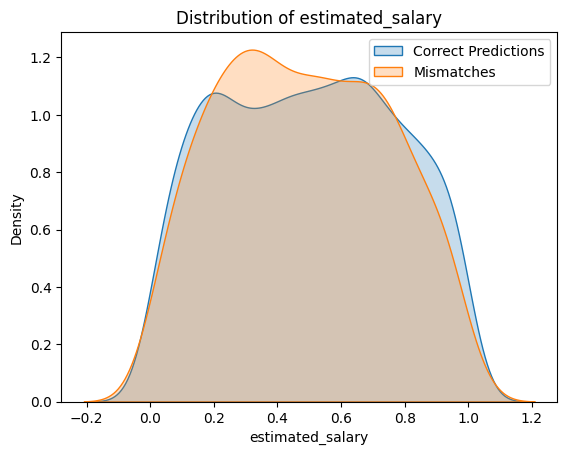

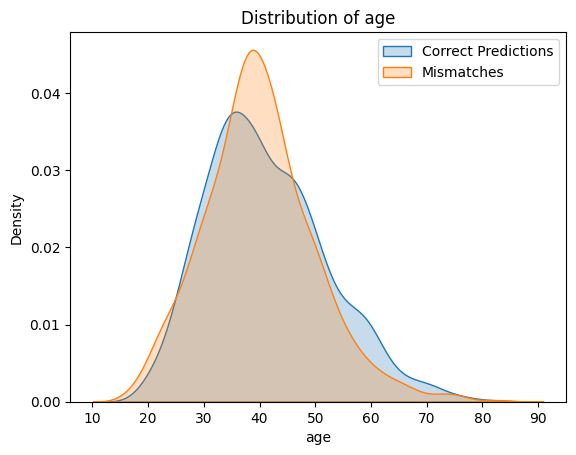

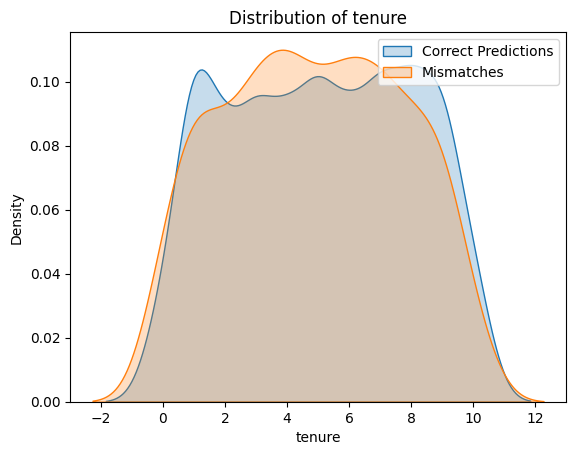

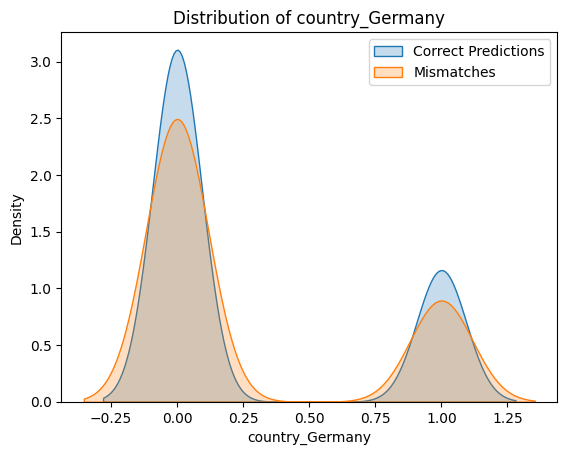

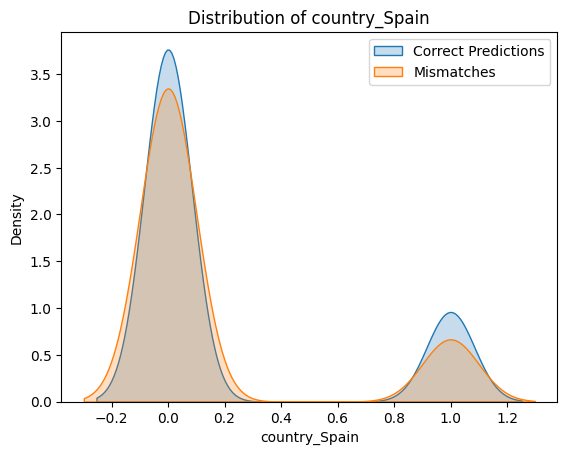

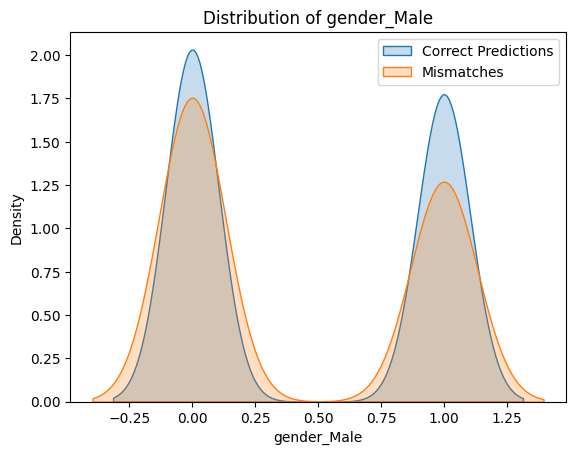

In [56]:
correct_matches = X_test.loc[~X_test.index.isin(mismatches.index)]

# Compare distributions of important features
for feature in ['credit_score', 'balance', 'estimated_salary', 'age', 'tenure', 'country_Germany', 'country_Spain', 'gender_Male']:
    plt.figure()
    sns.kdeplot(correct_matches[feature], label='Correct Predictions', fill=True)
    sns.kdeplot(mismatched_data[feature], label='Mismatches', fill=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()


In [57]:
from scipy.stats import ks_2samp

# Compare distributions using KS test
for feature in ['credit_score', 'balance', 'estimated_salary', 'age', 'tenure', 'country_Germany', 'country_Spain', 'gender_Male']:
    stat, p_value = ks_2samp(correct_matches[feature], mismatched_data[feature])
    print(f"KS Test for {feature}: Statistic={stat}, p-value={p_value}")


KS Test for credit_score: Statistic=0.03038598047914818, p-value=0.6589835705727881
KS Test for balance: Statistic=0.1585614463176575, p-value=6.821518174948883e-13
KS Test for estimated_salary: Statistic=0.040557897071872226, p-value=0.29985089691961125
KS Test for age: Statistic=0.08704192546583851, p-value=0.0003488546767070468
KS Test for tenure: Statistic=0.043559228039041706, p-value=0.2252127636404083
KS Test for country_Germany: Statistic=0.008657941437444543, p-value=0.9999999999771285
KS Test for country_Spain: Statistic=0.03709627329192547, p-value=0.40554163037393626
KS Test for gender_Male: Statistic=0.046285492457852705, p-value=0.1704291437999626


**KS Test Summary:**

The KS test results show that balance and age have significant differences between correct predictions and mismatches, with p-values of 6.82e-13 and 0.0003 respectively. This suggests that the model struggles with these features. Other features, such as credit_score, estimated_salary, tenure, country (Germany and Spain), and gender, show no significant differences between correct predictions and mismatches, indicating the model handles them more consistently.

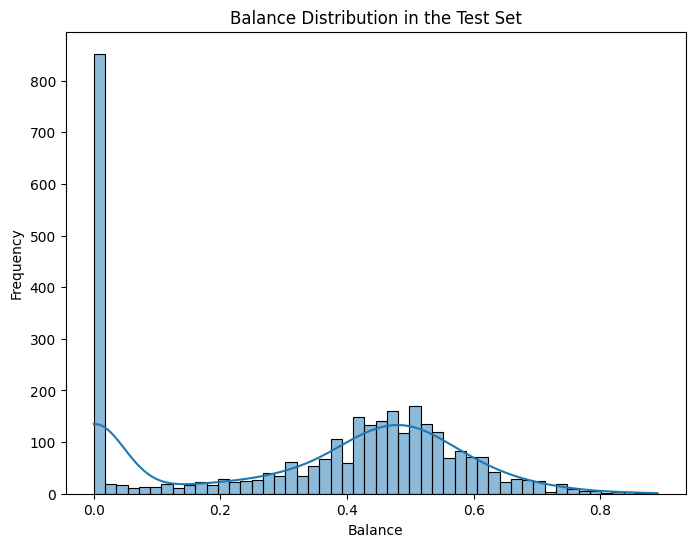

In [75]:
# Check the distribution of balance in the dataset
plt.figure(figsize=(8, 6))
sns.histplot(X_test['balance'], bins=50, kde=True)
plt.title('Balance Distribution in the Test Set')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()

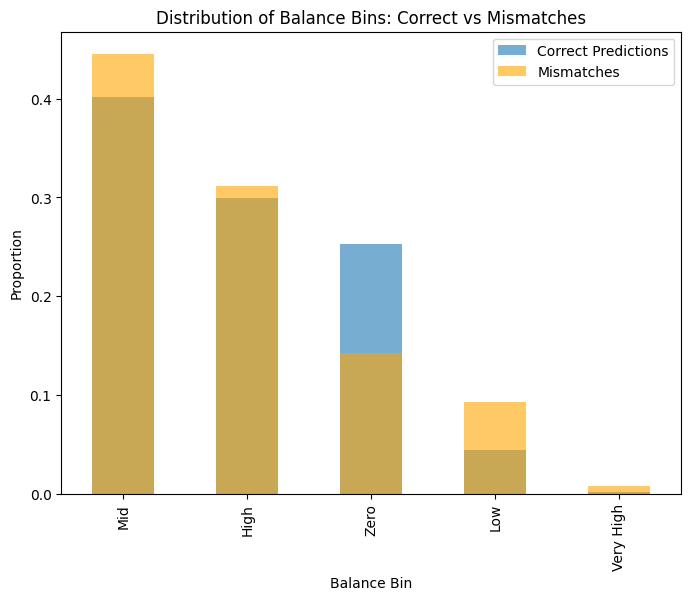

In [77]:
# Create finer balance bins that take the large number of zero balances into account
balance_bins = pd.cut(X_test['balance'], bins=[-1, 0, 0.2, 0.5, 0.8, np.inf], labels=['Zero', 'Low', 'Mid', 'High', 'Very High'])

balance_bins = balance_bins.astype(str)

# Add these bins to correct matches and mismatches
correct_matches.loc[correct_matches.index, 'balance_bin'] = balance_bins.loc[correct_matches.index]
mismatched_data.loc[mismatched_data.index, 'balance_bin'] = balance_bins.loc[mismatched_data.index]

# Plot the new balance bin distribution
plt.figure(figsize=(8, 6))
correct_matches['balance_bin'].value_counts(normalize=True).plot(kind='bar', alpha=0.6, label='Correct Predictions')
mismatched_data['balance_bin'].value_counts(normalize=True).plot(kind='bar', alpha=0.6, color='orange', label='Mismatches')
plt.title('Distribution of Balance Bins: Correct vs Mismatches')
plt.xlabel('Balance Bin')
plt.ylabel('Proportion')
plt.legend()
plt.show()

The model is struggling the most with customers in the Mid (0.2 - 0.5) and High (0.5 - 0.8) balance ranges, where most of the misclassifications happen. For customers with Zero balance, the model performs better, but there are still some errors. In the Low balance group (0 - 0.2), there are fewer customers, but the misclassification rate is higher than correct predictions. Finally, in the Very High balance group (above 0.8), most customers are misclassified, but there aren't many examples in this group, which might be why the model is struggling here.

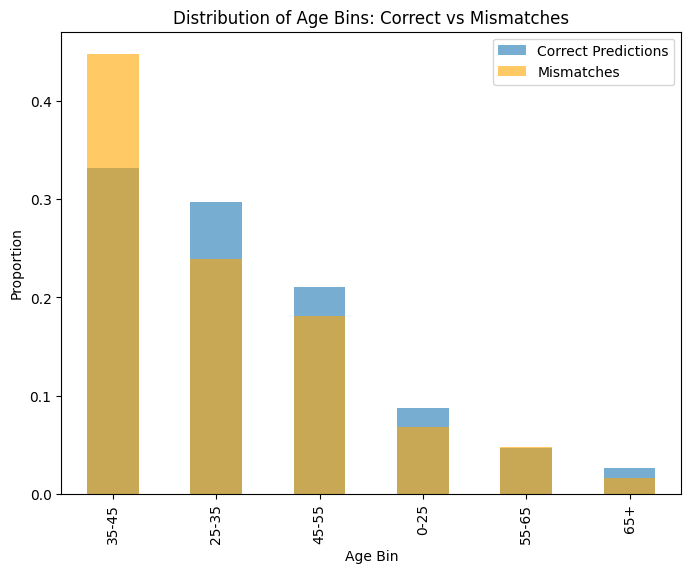

In [81]:
# Create bins for age
age_bins = pd.cut(X_test['age'], bins=[0, 25, 35, 45, 55, 65, np.inf], labels=['0-25', '25-35', '35-45', '45-55', '55-65', '65+'])

# Convert the bins to strings to avoid categorical mismatch issues
age_bins = age_bins.astype(str)

correct_matches.loc[correct_matches.index, 'age_bin'] = age_bins.loc[correct_matches.index]
mismatched_data.loc[mismatched_data.index, 'age_bin'] = age_bins.loc[mismatched_data.index]

# Plot the distribution of age bins for correct and incorrect predictions
plt.figure(figsize=(8, 6))
correct_matches['age_bin'].value_counts(normalize=True).plot(kind='bar', alpha=0.6, label='Correct Predictions')
mismatched_data['age_bin'].value_counts(normalize=True).plot(kind='bar', alpha=0.6, color='orange', label='Mismatches')
plt.title('Distribution of Age Bins: Correct vs Mismatches')
plt.xlabel('Age Bin')
plt.ylabel('Proportion')
plt.legend()
plt.show()


The model struggles the most with 35-45 years customers, where the majority of misclassifications occur. There are also significant errors in the 25-35 years and 45-55 years age groups, though the model does a bit better here. The model performs relatively well for younger (0-25 years) and older (55+ years) customers, with fewer mistakes in these age ranges. Overall, the model's performance improves as customers get older, particularly for those aged 55 and above.


In [85]:
from sklearn.metrics import accuracy_score

# Get baseline performance
y_pred = model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, np.round(y_pred))

# Function to calculate permutation importance
def permutation_importance(model, X_test, y_test, metric_fn):
    feature_importances = []
    for i in range(X_test.shape[1]):  # Iterate over each feature
        X_permuted = X_test.copy()
        X_permuted.iloc[:, i] = np.random.permutation(X_permuted.iloc[:, i])

        # Recalculate performance with the shuffled feature
        y_permuted_pred = model.predict(X_permuted)
        permuted_accuracy = metric_fn(y_test, np.round(y_permuted_pred))

        # Calculate the drop in performance (importance of the feature)
        importance = baseline_accuracy - permuted_accuracy
        feature_importances.append(importance)

    return np.array(feature_importances)

# Use accuracy as the performance metric
feature_importances = permutation_importance(model, X_test, y_test, accuracy_score)

# Print the importance scores for each feature
for i, importance in enumerate(feature_importances):
    print(f"Feature {i}: {importance}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Feature 0: -0.003138731952291307
Feature 1: 0.08537350910232266
Feature 2: 0.0037664783427495685
Feature 3: 0.011299435028248594
Feature 4: 0.1095417451349655
Feature 5: 0.008474576271186418
Feature 6: 0.06089139987445069
Feature 7: 0.0006277463904582614
Feature 8: 0.006591337099811634
Feature 9: 0.010671688637790333
Feature 10: 0.02291274325172632


Feature 0 (credit_score): -0.003138731952291307
Feature 1 (age): 0.08537350910232266
Feature 2 (tenure): 0.0037664783427495685
Feature 3 (balance): 0.011299435028248594
Feature 4 (products_number): 0.1095417451349655
Feature 5 (credit_card): 0.008474576271186418
Feature 6 (active_member): 0.06089139987445069
Feature 7 (estimated_salary): 0.0006277463904582614
Feature 8 (country_Germany): 0.006591337099811634
Feature 9 (country_Spain): 0.010671688637790333
Feature 10 (gender_Male): 0.02291274325172632


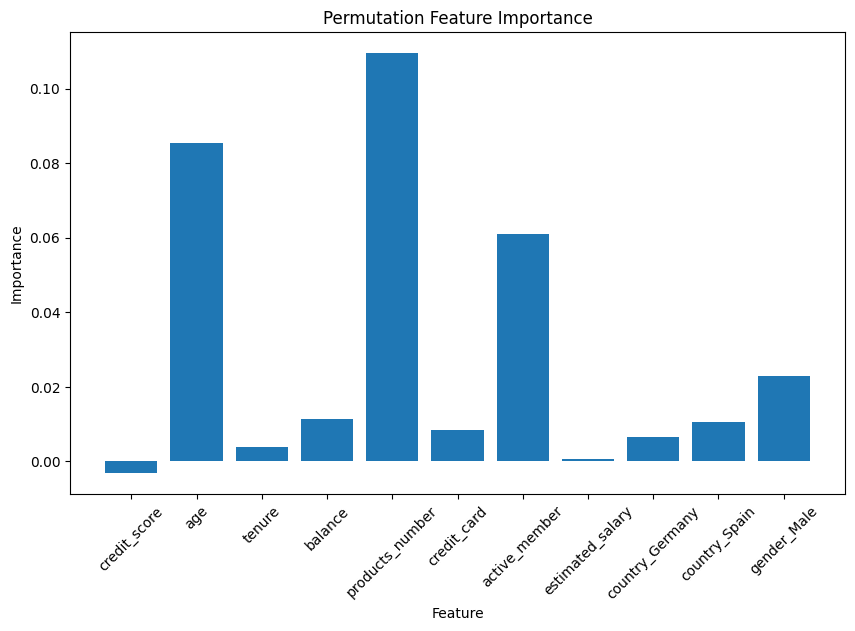

In [90]:
feature_names = X_train.columns

# Print feature names along with their importance
for i, importance in enumerate(feature_importances):
    print(f"Feature {i} ({feature_names[i]}): {importance}")

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.show()

- Products Number has the highest importance, meaning that the number of products a customer has plays a crucial role in determining the model's predictions.

- Age and Active Member are the next most important features, suggesting that customer age and whether they are actively engaged with the bank are significant factors in predicting outcomes.

- Balance and Gender (Male) also have some importance, though less than the top features, indicating that they still contribute meaningfully to the model’s predictions.

- Country_Germany, Country_Spain, and Tenure have relatively low importance, indicating that these features may not strongly affect the model's decision-making.

- Estimated Salary has virtually no importance in the model’s predictions, suggesting that salary does not significantly impact the model's outcomes.

In [37]:
#model.save('bank_churn.keras')

#from google.colab import files
#files.download('bank_churn.keras')

In [38]:
#import joblib
#joblib.dump(scaler, 'minmax_scaler.pkl')
#files.download('minmax_scaler.pkl')

In [39]:
# To load the model and scaler later:
# scaler = joblib.load('minmax_scaler.pkl')
# from keras.models import load_model
# loaded_model = load_model('bank_churn.keras')